In [1]:
import nest_asyncio
nest_asyncio.apply()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import collections
import dp_accounting
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff

2023-03-24 19:59:57.951734: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-24 19:59:59.649625: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-24 19:59:59.649679: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-24 19:59:59.649684: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
def get_emnist_dataset():
  emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data(
      only_digits=True)

  def element_fn(element):
    return collections.OrderedDict(
        x=tf.expand_dims(element['pixels'], -1), y=element['label'])

  def preprocess_train_dataset(dataset):
    # Use buffer_size same as the maximum client dataset size,
    # 418 for Federated EMNIST
    return (dataset.map(element_fn)
                   .shuffle(buffer_size=418)
                   .repeat(1)
                   .batch(32, drop_remainder=False))

  def preprocess_test_dataset(dataset):
    return dataset.map(element_fn).batch(128, drop_remainder=False)

  emnist_train = emnist_train.preprocess(preprocess_train_dataset)
  emnist_test = preprocess_test_dataset(
      emnist_test.create_tf_dataset_from_all_clients())
  return emnist_train, emnist_test

train_data, test_data = get_emnist_dataset()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [3]:
def my_model_fn():
  model = tf.keras.models.Sequential([
      tf.keras.layers.Reshape(input_shape=(28, 28, 1), target_shape=(28 * 28,)),
      tf.keras.layers.Dense(200, activation=tf.nn.relu),
      tf.keras.layers.Dense(200, activation=tf.nn.relu),
      tf.keras.layers.Dense(10)])
  return tff.learning.models.from_keras_model(
      keras_model=model,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      input_spec=test_data.element_spec,
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [4]:
total_clients = len(train_data.client_ids)
clients_per_thread = 5

def train(rounds, noise_multiplier, clients_per_round, data_frame):
  # Using the `dp_aggregator` here turns on differential privacy with adaptive
  # clipping.
  aggregation_factory = tff.learning.model_update_aggregator.dp_aggregator(
      noise_multiplier, clients_per_round)

  # We use Poisson subsampling which gives slightly tighter privacy guarantees
  # compared to having a fixed number of clients per round. The actual number of
  # clients per round is stochastic with mean clients_per_round.
  sampling_prob = clients_per_round / total_clients

  # Build a federated averaging process.
  # Typically a non-adaptive server optimizer is used because the noise in the
  # updates can cause the second moment accumulators to become very large
  # prematurely.
  learning_process = tff.learning.algorithms.build_unweighted_fed_avg(
        my_model_fn,
        client_optimizer_fn=lambda: tf.keras.optimizers.SGD(0.01),
        server_optimizer_fn=lambda: tf.keras.optimizers.SGD(1.0, momentum=0.9),
        model_aggregator=aggregation_factory)

  eval_process = tff.learning.build_federated_evaluation(my_model_fn)

  # Training loop.
  state = learning_process.initialize()
  for round in range(rounds):
    if round % 5 == 0:
      model_weights = learning_process.get_model_weights(state)
      metrics = eval_process(model_weights, [test_data])['eval']
      if round < 25 or round % 25 == 0:
        print(f'Round {round:3d}: {metrics}')
      data_frame = data_frame.append({'Round': round,
                                      'NoiseMultiplier': noise_multiplier,
                                      **metrics}, ignore_index=True)

    # Sample clients for a round. Note that if your dataset is large and
    # sampling_prob is small, it would be faster to use gap sampling.
    x = np.random.uniform(size=total_clients)
    sampled_clients = [
        train_data.client_ids[i] for i in range(total_clients)
        if x[i] < sampling_prob]
    sampled_train_data = [
        train_data.create_tf_dataset_for_client(client)
        for client in sampled_clients]

    # Use selected clients for update.
    result = learning_process.next(state, sampled_train_data)
    state = result.state
    metrics = result.metrics

  model_weights = learning_process.get_model_weights(state)
  metrics = eval_process(model_weights, [test_data])['eval']
  print(f'Round {rounds:3d}: {metrics}')
  data_frame = data_frame.append({'Round': rounds,
                                  'NoiseMultiplier': noise_multiplier,
                                  **metrics}, ignore_index=True)

  return data_frame

In [5]:
data_frame = pd.DataFrame()
rounds = 100
clients_per_round = 50

for noise_multiplier in [0.0, 0.5, 0.75, 1.0]:
  print(f'Starting training with noise multiplier: {noise_multiplier}')
  data_frame = train(rounds, noise_multiplier, clients_per_round, data_frame)
  print()

Starting training with noise multiplier: 0.0


/tmp/ipykernel_2811248/2919981168.py:25: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval_process = tff.learning.build_federated_evaluation(my_model_fn)


Round   0: OrderedDict([('sparse_categorical_accuracy', 0.10890968), ('loss', 2.7295876), ('num_examples', 40832), ('num_batches', 319)])
Round   5: OrderedDict([('sparse_categorical_accuracy', 0.102566615), ('loss', 2.2622125), ('num_examples', 40832), ('num_batches', 319)])
Round  10: OrderedDict([('sparse_categorical_accuracy', 0.2606289), ('loss', 2.1828823), ('num_examples', 40832), ('num_batches', 319)])
Round  15: OrderedDict([('sparse_categorical_accuracy', 0.2778458), ('loss', 2.0963097), ('num_examples', 40832), ('num_batches', 319)])
Round  20: OrderedDict([('sparse_categorical_accuracy', 0.4783503), ('loss', 1.9062573), ('num_examples', 40832), ('num_batches', 319)])
Round  25: OrderedDict([('sparse_categorical_accuracy', 0.4750196), ('loss', 1.7378654), ('num_examples', 40832), ('num_batches', 319)])
Round  50: OrderedDict([('sparse_categorical_accuracy', 0.7119416), ('loss', 0.99001825), ('num_examples', 40832), ('num_batches', 319)])
Round  75: OrderedDict([('sparse_cate

/tmp/ipykernel_2811248/2919981168.py:25: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval_process = tff.learning.build_federated_evaluation(my_model_fn)


Round   0: OrderedDict([('sparse_categorical_accuracy', 0.09952978), ('loss', 2.6291265), ('num_examples', 40832), ('num_batches', 319)])
Round   5: OrderedDict([('sparse_categorical_accuracy', 0.23195043), ('loss', 2.2448132), ('num_examples', 40832), ('num_batches', 319)])
Round  10: OrderedDict([('sparse_categorical_accuracy', 0.31316125), ('loss', 2.1622581), ('num_examples', 40832), ('num_batches', 319)])
Round  15: OrderedDict([('sparse_categorical_accuracy', 0.3643711), ('loss', 2.0141838), ('num_examples', 40832), ('num_batches', 319)])
Round  20: OrderedDict([('sparse_categorical_accuracy', 0.576827), ('loss', 1.8008113), ('num_examples', 40832), ('num_batches', 319)])
Round  25: OrderedDict([('sparse_categorical_accuracy', 0.5860599), ('loss', 1.5483123), ('num_examples', 40832), ('num_batches', 319)])
Round  50: OrderedDict([('sparse_categorical_accuracy', 0.7086844), ('loss', 0.91144603), ('num_examples', 40832), ('num_batches', 319)])
Round  75: OrderedDict([('sparse_categ

/tmp/ipykernel_2811248/2919981168.py:25: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval_process = tff.learning.build_federated_evaluation(my_model_fn)


Round   0: OrderedDict([('sparse_categorical_accuracy', 0.1122404), ('loss', 2.70805), ('num_examples', 40832), ('num_batches', 319)])
Round   5: OrderedDict([('sparse_categorical_accuracy', 0.12061618), ('loss', 2.2780042), ('num_examples', 40832), ('num_batches', 319)])
Round  10: OrderedDict([('sparse_categorical_accuracy', 0.108223945), ('loss', 2.1699195), ('num_examples', 40832), ('num_batches', 319)])
Round  15: OrderedDict([('sparse_categorical_accuracy', 0.44283894), ('loss', 1.9933114), ('num_examples', 40832), ('num_batches', 319)])
Round  20: OrderedDict([('sparse_categorical_accuracy', 0.502547), ('loss', 1.7672884), ('num_examples', 40832), ('num_batches', 319)])
Round  25: OrderedDict([('sparse_categorical_accuracy', 0.5904438), ('loss', 1.5598935), ('num_examples', 40832), ('num_batches', 319)])
Round  50: OrderedDict([('sparse_categorical_accuracy', 0.73937106), ('loss', 0.8593538), ('num_examples', 40832), ('num_batches', 319)])
Round  75: OrderedDict([('sparse_catego

/tmp/ipykernel_2811248/2919981168.py:25: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval_process = tff.learning.build_federated_evaluation(my_model_fn)


Round   0: OrderedDict([('sparse_categorical_accuracy', 0.09982367), ('loss', 2.6488812), ('num_examples', 40832), ('num_batches', 319)])
Round   5: OrderedDict([('sparse_categorical_accuracy', 0.14907426), ('loss', 2.2510018), ('num_examples', 40832), ('num_batches', 319)])
Round  10: OrderedDict([('sparse_categorical_accuracy', 0.13682896), ('loss', 2.2472742), ('num_examples', 40832), ('num_batches', 319)])
Round  15: OrderedDict([('sparse_categorical_accuracy', 0.3812451), ('loss', 2.0510807), ('num_examples', 40832), ('num_batches', 319)])
Round  20: OrderedDict([('sparse_categorical_accuracy', 0.43578565), ('loss', 1.8726066), ('num_examples', 40832), ('num_batches', 319)])
Round  25: OrderedDict([('sparse_categorical_accuracy', 0.5069553), ('loss', 1.6269135), ('num_examples', 40832), ('num_batches', 319)])
Round  50: OrderedDict([('sparse_categorical_accuracy', 0.67140967), ('loss', 1.0116669), ('num_examples', 40832), ('num_batches', 319)])
Round  75: OrderedDict([('sparse_cat

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def make_plot(data_frame):
  plt.figure(figsize=(15, 5))

  dff = data_frame.rename(
      columns={'sparse_categorical_accuracy': 'Accuracy', 'loss': 'Loss'})

  plt.subplot(121)
  sns.lineplot(data=dff, x='Round', y='Accuracy', hue='NoiseMultiplier', palette='dark')
  plt.subplot(122)
  sns.lineplot(data=dff, x='Round', y='Loss', hue='NoiseMultiplier', palette='dark')

In [6]:
make_plot(data_frame)

NameError: name 'data_frame' is not defined

In [8]:
total_clients = 3383
rounds = 100
noise_to_clients_ratio = 0.01
target_delta = 1e-5
target_eps = 2

# Initialize arguments to dp_accounting.calibrate_dp_mechanism.

# No-arg callable that returns a fresh accountant.
make_fresh_accountant = dp_accounting.rdp.RdpAccountant

# Create function that takes expected clients per round and returns a 
# dp_accounting.DpEvent representing the full training process.
def make_event_from_param(clients_per_round):
  q = clients_per_round / total_clients
  noise_multiplier = clients_per_round * noise_to_clients_ratio
  gaussian_event = dp_accounting.GaussianDpEvent(noise_multiplier)
  sampled_event = dp_accounting.PoissonSampledDpEvent(q, gaussian_event)
  composed_event = dp_accounting.SelfComposedDpEvent(sampled_event, rounds)
  return composed_event

# Create object representing the search range [1, 3383].
bracket_interval = dp_accounting.ExplicitBracketInterval(1, total_clients)

for target_eps in [2.0, 4.0, 6.0, 8.0]:
  # Perform search for smallest clients_per_round achieving the target privacy.
  clients_per_round = dp_accounting.calibrate_dp_mechanism(
      make_fresh_accountant, make_event_from_param, target_eps, target_delta,
      bracket_interval, discrete=True
  )

  noise_multiplier = clients_per_round * noise_to_clients_ratio
  print(f'To get ({target_eps}, {target_delta})-DP, use {clients_per_round} '
        f'clients with noise multiplier {noise_multiplier}.')

To get (2.0, 1e-05)-DP, use 120 clients with noise multiplier 1.2.
To get (4.0, 1e-05)-DP, use 77 clients with noise multiplier 0.77.
To get (6.0, 1e-05)-DP, use 63 clients with noise multiplier 0.63.
To get (8.0, 1e-05)-DP, use 58 clients with noise multiplier 0.58.


/tmp/ipykernel_339615/2919981168.py:25: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval_process = tff.learning.build_federated_evaluation(my_model_fn)


Round   0: OrderedDict([('sparse_categorical_accuracy', 0.089096785), ('loss', 2.5037227), ('num_examples', 40832), ('num_batches', 319)])
Round   5: OrderedDict([('sparse_categorical_accuracy', 0.14030662), ('loss', 2.2415378), ('num_examples', 40832), ('num_batches', 319)])
Round  10: OrderedDict([('sparse_categorical_accuracy', 0.35117066), ('loss', 2.1280785), ('num_examples', 40832), ('num_batches', 319)])
Round  15: OrderedDict([('sparse_categorical_accuracy', 0.37850216), ('loss', 1.9435989), ('num_examples', 40832), ('num_batches', 319)])
Round  20: OrderedDict([('sparse_categorical_accuracy', 0.58772534), ('loss', 1.6903455), ('num_examples', 40832), ('num_batches', 319)])
Round  25: OrderedDict([('sparse_categorical_accuracy', 0.623751), ('loss', 1.4351633), ('num_examples', 40832), ('num_batches', 319)])
Round  50: OrderedDict([('sparse_categorical_accuracy', 0.74958366), ('loss', 0.7968385), ('num_examples', 40832), ('num_batches', 319)])
Round  75: OrderedDict([('sparse_ca

/tmp/ipykernel_339615/2919981168.py:25: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval_process = tff.learning.build_federated_evaluation(my_model_fn)


Round   0: OrderedDict([('sparse_categorical_accuracy', 0.1122404), ('loss', 2.670899), ('num_examples', 40832), ('num_batches', 319)])
Round   5: OrderedDict([('sparse_categorical_accuracy', 0.114052705), ('loss', 2.2494056), ('num_examples', 40832), ('num_batches', 319)])
Round  10: OrderedDict([('sparse_categorical_accuracy', 0.29888323), ('loss', 2.1533666), ('num_examples', 40832), ('num_batches', 319)])
Round  15: OrderedDict([('sparse_categorical_accuracy', 0.44418594), ('loss', 1.9986225), ('num_examples', 40832), ('num_batches', 319)])
Round  20: OrderedDict([('sparse_categorical_accuracy', 0.5303928), ('loss', 1.7948434), ('num_examples', 40832), ('num_batches', 319)])
Round  25: OrderedDict([('sparse_categorical_accuracy', 0.6351636), ('loss', 1.5544455), ('num_examples', 40832), ('num_batches', 319)])
Round  50: OrderedDict([('sparse_categorical_accuracy', 0.7698129), ('loss', 0.793626), ('num_examples', 40832), ('num_batches', 319)])
Round  75: OrderedDict([('sparse_catego

/tmp/ipykernel_339615/2919981168.py:25: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval_process = tff.learning.build_federated_evaluation(my_model_fn)


Round   0: OrderedDict([('sparse_categorical_accuracy', 0.10219926), ('loss', 2.5661886), ('num_examples', 40832), ('num_batches', 319)])
Round   5: OrderedDict([('sparse_categorical_accuracy', 0.24387735), ('loss', 2.2343228), ('num_examples', 40832), ('num_batches', 319)])
Round  10: OrderedDict([('sparse_categorical_accuracy', 0.2997404), ('loss', 2.1526988), ('num_examples', 40832), ('num_batches', 319)])
Round  15: OrderedDict([('sparse_categorical_accuracy', 0.48199943), ('loss', 2.007953), ('num_examples', 40832), ('num_batches', 319)])
Round  20: OrderedDict([('sparse_categorical_accuracy', 0.5253233), ('loss', 1.8116913), ('num_examples', 40832), ('num_batches', 319)])
Round  25: OrderedDict([('sparse_categorical_accuracy', 0.6893123), ('loss', 1.5694035), ('num_examples', 40832), ('num_batches', 319)])
Round  50: OrderedDict([('sparse_categorical_accuracy', 0.7354526), ('loss', 0.86148494), ('num_examples', 40832), ('num_batches', 319)])
Round  75: OrderedDict([('sparse_categ

/tmp/ipykernel_339615/2919981168.py:25: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval_process = tff.learning.build_federated_evaluation(my_model_fn)


Round   0: OrderedDict([('sparse_categorical_accuracy', 0.10538303), ('loss', 2.4593153), ('num_examples', 40832), ('num_batches', 319)])
Round   5: OrderedDict([('sparse_categorical_accuracy', 0.112436324), ('loss', 2.2380195), ('num_examples', 40832), ('num_batches', 319)])
Round  10: OrderedDict([('sparse_categorical_accuracy', 0.30160168), ('loss', 2.1274316), ('num_examples', 40832), ('num_batches', 319)])
Round  15: OrderedDict([('sparse_categorical_accuracy', 0.43377742), ('loss', 1.940302), ('num_examples', 40832), ('num_batches', 319)])
Round  20: OrderedDict([('sparse_categorical_accuracy', 0.5801332), ('loss', 1.7053676), ('num_examples', 40832), ('num_batches', 319)])
Round  25: OrderedDict([('sparse_categorical_accuracy', 0.59335816), ('loss', 1.4933953), ('num_examples', 40832), ('num_batches', 319)])
Round  50: OrderedDict([('sparse_categorical_accuracy', 0.7600656), ('loss', 0.80462205), ('num_examples', 40832), ('num_batches', 319)])
Round  75: OrderedDict([('sparse_ca

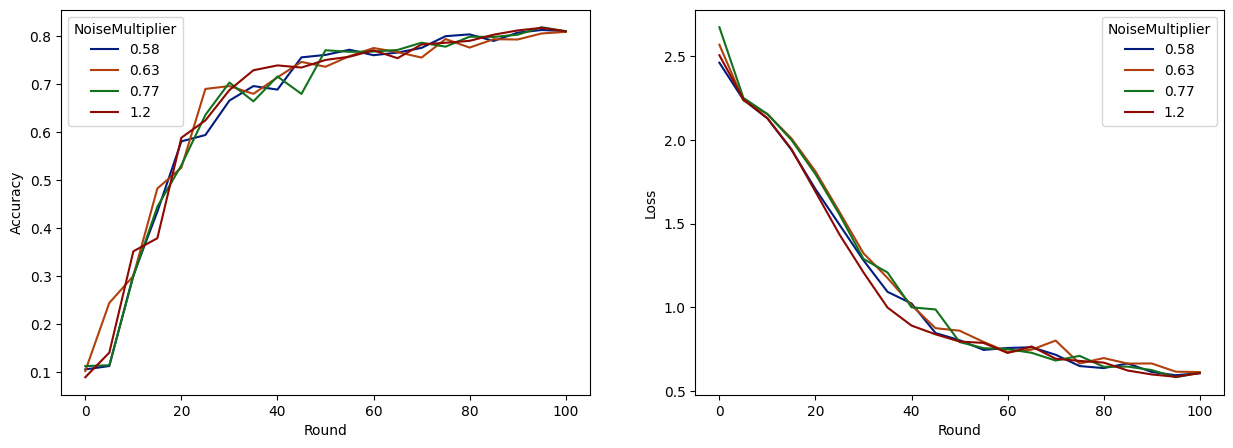

In [9]:
rounds = 100

data_frame = pd.DataFrame()
for (noise_multiplier, clients_per_round) in [(1.2,120), (0.77,77), (0.63,63), (0.58,58)]:
    data_frame = train(rounds, noise_multiplier, clients_per_round, data_frame)

make_plot(data_frame)